# Pre-Processing

## Mount and Unzip in colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/AUEB/MURA-v1.1.zip" -d /content/


## Inspect CSV files


In [ ]:
import pandas as pd

df = pd.read_csv('/content/MURA-v1.1/train_image_paths.csv')
print(df.head())


  MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...                 
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...                 
2  MURA-v1.1/train/XR_SHOULDER/patient00002/study...                 
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...                 
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...                 


## Prepare the Full DataFrame

In [ ]:

df_train = pd.read_csv('/content/MURA-v1.1/train_image_paths.csv')
print(df_train.columns)


Index(['MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png'], dtype='object')


In [ ]:
import pandas as pd
import os

df_train = pd.read_csv('/content/MURA-v1.1/train_image_paths.csv', header=None)
df_train.columns = ['image_path']
df_train['path'] = df_train['image_path'].apply(lambda x: os.path.join('/content', x))
df_train['label'] = df_train['image_path'].apply(lambda x: 1 if 'positive' in x else 0)
df_train['body_part'] = df_train['image_path'].apply(lambda x: x.split('/')[2])  # e.g., 'XR_SHOULDER'


In [ ]:
from sklearn.model_selection import train_test_split

# Create a stratification key combining body part + label
df_train['stratify_group'] = df_train['body_part'] + "_" + df_train['label'].astype(str)

# Stratified 80/20 split
df_train_final, df_val_final = train_test_split(
    df_train,
    test_size=0.2,
    random_state=42,
    stratify=df_train['stratify_group']
)

In [ ]:

# Dropping the helper column
df_train_final = df_train_final.drop(columns=['stratify_group'])
df_val_final = df_val_final.drop(columns=['stratify_group'])

In [ ]:
df_test = pd.read_csv('/content/MURA-v1.1/valid_image_paths.csv', header=None)
df_test.columns = ['image_path']
df_test['path'] = df_test['image_path'].apply(lambda x: os.path.join('/content', x))
df_test['label'] = df_test['image_path'].apply(lambda x: 1 if 'positive' in x else 0)
df_test['body_part'] = df_test['image_path'].apply(lambda x: x.split('/')[2])  # e.g., XR_WRIST


In [ ]:
# Encode body_part as part_idx for conditioning
body_parts = sorted(df_train_final['body_part'].unique())  # Ensure consistent order
part_to_index = {part: idx for idx, part in enumerate(body_parts)}

for df in [df_train_final, df_val_final, df_test]:
    df['part_idx'] = df['body_part'].map(part_to_index)


In [ ]:
# Distribution and Sanity Check

print("Training set:")
print(df_train_final['body_part'].value_counts(normalize=True))

print("\nValidation set:")
print(df_val_final['body_part'].value_counts(normalize=True))


Training set:
body_part
XR_WRIST       0.264960
XR_SHOULDER    0.227637
XR_HAND        0.150581
XR_FINGER      0.138695
XR_ELBOW       0.133974
XR_FOREARM     0.049582
XR_HUMERUS     0.034572
Name: proportion, dtype: float64

Validation set:
body_part
XR_WRIST       0.264874
XR_SHOULDER    0.227656
XR_HAND        0.150638
XR_FINGER      0.138821
XR_ELBOW       0.133931
XR_FOREARM     0.049579
XR_HUMERUS     0.034501
Name: proportion, dtype: float64


## Dataset and DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch


class MuraDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'path']
        label = self.df.loc[idx, 'label']
        part_idx = self.df.loc[idx, 'part_idx']
        image = Image.open(img_path).convert("L")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long), torch.tensor(part_idx, dtype=torch.long)




## Loaders and Transforms


In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Grayscale: 1 channel
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Grayscale: 1 channel
])


In [ ]:
from torch.utils.data import DataLoader

# Train
train_dataset = MuraDataset(df_train_final, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

# Validation
val_dataset = MuraDataset(df_val_final, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Test
test_dataset = MuraDataset(df_test, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# Custom CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNNWithPart(nn.Module):
    def __init__(self, num_parts):
        super(CustomCNNWithPart, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Embed body part index (e.g., 7 parts → 16-dim embedding)
        self.part_embedding = nn.Embedding(num_parts, 16)

        # Dropout + FC
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 28 * 28 + 16, 256)
        self.fc2 = nn.Linear(256, 2)  # binary classification

    def forward(self, x, part_idx):
        x = self.pool(F.relu(self.conv1(x)))   # (B, 32, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))   # (B, 64, 56, 56)
        x = self.pool(F.relu(self.conv3(x)))   # (B, 128, 28, 28)

        x = x.view(x.size(0), -1)              # Flatten CNN features
        part_feat = self.part_embedding(part_idx)  # Shape: (B, 16)

        x = torch.cat([x, part_feat], dim=1)   # Shape: (B, 100352 + 16)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_parts = len(part_to_index)
model = CustomCNNWithPart(num_parts).to(device)


## Focal Loss


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        """
        alpha: weighting factor for class 1 (abnormal)
        gamma: focusing parameter
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # pt = softmax prob of true class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [ ]:
import torch.optim as optim

criterion = FocalLoss(alpha=0.25, gamma=2.0)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

best_val_loss = float('inf')
early_stop_counter = 0
early_stop_patience = 5


## Training and Validation Loops

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0

    for images, labels, part_idxs in loader:
        images, labels, part_idxs = images.to(device), labels.to(device), part_idxs.to(device)

        optimizer.zero_grad()
        outputs = model(images, part_idxs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy


def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for images, labels, part_idxs in loader:
            images, labels, part_idxs = images.to(device), labels.to(device), part_idxs.to(device)

            outputs = model(images, part_idxs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy


## Training for a Few Epoch

In [ ]:
epochs = 50

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Step scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pt")  # Save best model
    else:
        early_stop_counter += 1
        print(f"Early stop patience: {early_stop_counter}/{early_stop_patience}")

        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break


Epoch 1/50 | Train Loss: 0.0405, Acc: 0.6193 | Val Loss: 0.0403, Acc: 0.6267
Epoch 2/50 | Train Loss: 0.0404, Acc: 0.6242 | Val Loss: 0.0402, Acc: 0.6262
Epoch 3/50 | Train Loss: 0.0403, Acc: 0.6282 | Val Loss: 0.0403, Acc: 0.6221
Early stop patience: 1/5
Epoch 4/50 | Train Loss: 0.0402, Acc: 0.6269 | Val Loss: 0.0399, Acc: 0.6352
Epoch 5/50 | Train Loss: 0.0399, Acc: 0.6340 | Val Loss: 0.0397, Acc: 0.6387
Epoch 6/50 | Train Loss: 0.0398, Acc: 0.6374 | Val Loss: 0.0399, Acc: 0.6358
Early stop patience: 1/5
Epoch 7/50 | Train Loss: 0.0397, Acc: 0.6397 | Val Loss: 0.0395, Acc: 0.6452
Epoch 8/50 | Train Loss: 0.0395, Acc: 0.6461 | Val Loss: 0.0394, Acc: 0.6424
Epoch 9/50 | Train Loss: 0.0394, Acc: 0.6494 | Val Loss: 0.0392, Acc: 0.6512
Epoch 10/50 | Train Loss: 0.0393, Acc: 0.6510 | Val Loss: 0.0390, Acc: 0.6584
Epoch 11/50 | Train Loss: 0.0392, Acc: 0.6554 | Val Loss: 0.0389, Acc: 0.6509
Epoch 12/50 | Train Loss: 0.0390, Acc: 0.6575 | Val Loss: 0.0388, Acc: 0.6554
Epoch 13/50 | Train Los

## Final Evaluation on Test Set

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_on_test(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels, part_idxs in test_loader:
            images = images.to(device)
            part_idxs = part_idxs.to(device)
            outputs = model(images, part_idxs)

            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = outputs.argmax(dim=1).cpu().numpy()

            all_labels.extend(labels.numpy())
            all_preds.extend(preds)
            all_probs.extend(probs)

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    auc_score = roc_auc_score(all_labels, all_probs)
    print(f"ROC AUC Score: {auc_score:.4f}")


## Run on Test

In [ ]:
evaluate_on_test(model, test_loader)


Classification Report:
              precision    recall  f1-score   support

           0     0.6511    0.7612    0.7019      1667
           1     0.6811    0.5556    0.6120      1530

    accuracy                         0.6628      3197
   macro avg     0.6661    0.6584    0.6569      3197
weighted avg     0.6655    0.6628    0.6588      3197

ROC AUC Score: 0.7272


# Visuals

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

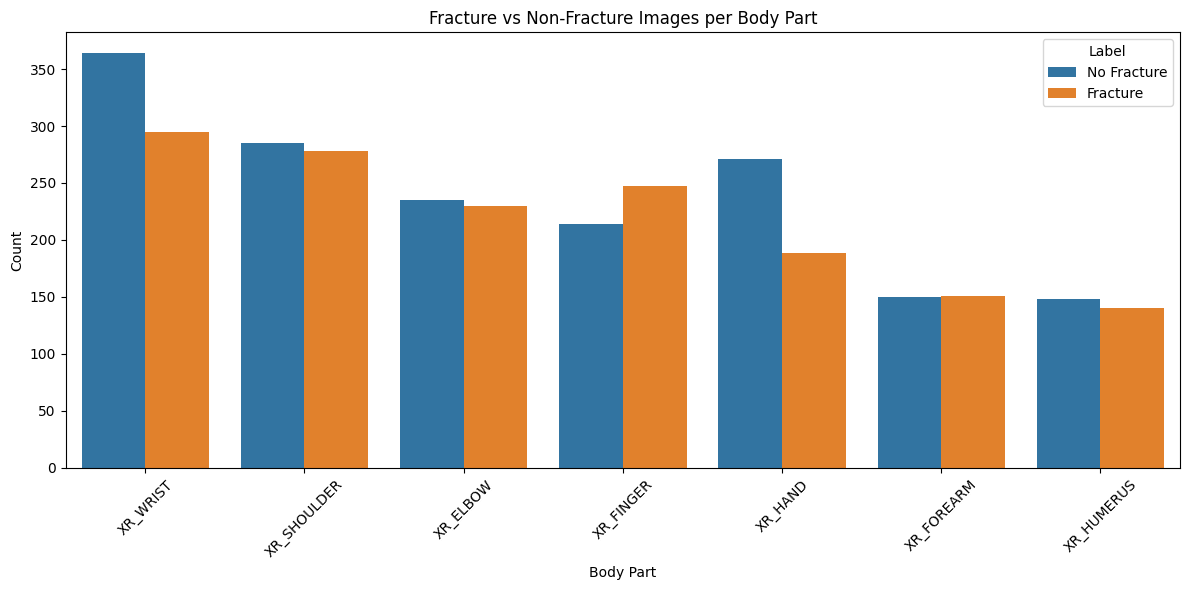

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='body_part', hue='label', order=df['body_part'].value_counts().index)
plt.title('Fracture vs Non-Fracture Images per Body Part')
plt.xlabel('Body Part')
plt.ylabel('Count')
plt.legend(title='Label', labels=['No Fracture', 'Fracture'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
print(f"Train images: {len(df_train_final)}")
print(f"Validation images: {len(df_val_final)}")
print(f"Test images: {len(df_test)}")  # If you made your own test set


Train images: 29446
Validation images: 7362
Test images: 3197


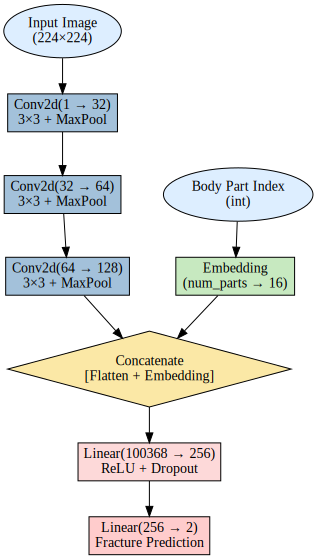

In [ ]:
from graphviz import Digraph

def custom_cnn_styled():
    dot = Digraph(comment='Custom CNN Architecture')
    dot.attr(rankdir='TB', splines='spline', nodesep='0.6', ranksep='0.5')

    # INPUTS
    dot.node('input', 'Input Image\n(224×224)', shape='ellipse', style='filled', fillcolor='#DDEEFF')
    dot.node('part', 'Body Part Index\n(int)', shape='ellipse', style='filled', fillcolor='#DDEEFF')

    # CONV LAYERS
    dot.node('conv1', 'Conv2d(1 → 32)\n3×3 + MaxPool', shape='box', style='filled', fillcolor='#A3C1DA')
    dot.node('conv2', 'Conv2d(32 → 64)\n3×3 + MaxPool', shape='box', style='filled', fillcolor='#A3C1DA')
    dot.node('conv3', 'Conv2d(64 → 128)\n3×3 + MaxPool', shape='box', style='filled', fillcolor='#A3C1DA')

    # EMBEDDING
    dot.node('embed', 'Embedding\n(num_parts → 16)', shape='box', style='filled', fillcolor='#C7E9C0')

    # CONCAT
    dot.node('concat', 'Concatenate\n[Flatten + Embedding]', shape='diamond', style='filled', fillcolor='#FBE8A6')

    # FC LAYERS
    dot.node('fc1', 'Linear(100368 → 256)\nReLU + Dropout', shape='box', style='filled', fillcolor='#FDD9D9')
    dot.node('fc2', 'Linear(256 → 2)\nFracture Prediction', shape='box', style='filled', fillcolor='#FFCCCC')

    # CONNECTIONS
    dot.edge('input', 'conv1')
    dot.edge('conv1', 'conv2')
    dot.edge('conv2', 'conv3')
    dot.edge('conv3', 'concat')

    dot.edge('part', 'embed')
    dot.edge('embed', 'concat')

    dot.edge('concat', 'fc1')
    dot.edge('fc1', 'fc2')

    return dot

# Save and display the graph
cnn_diagram = custom_cnn_styled()
cnn_diagram.render(filename='custom_cnn_architecture', format='png', cleanup=False)
cnn_diagram.view()  # Open the image

display(cnn_diagram)